# Neural Transfer

## Input images

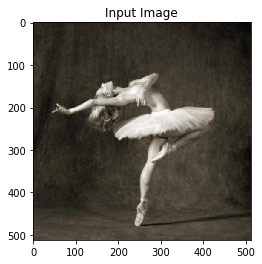

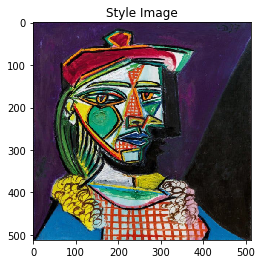

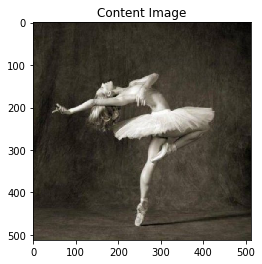

In [1]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

np.random.seed(37)
torch.manual_seed(37)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_image_size():
    imsize = 512 if torch.cuda.is_available() else 128
    return imsize

def get_loader():
    image_size = get_image_size()
    loader = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()]) 
    return loader

def get_unloader():
    unloader = transforms.ToPILImage()
    return unloader

def image_loader(image_name):
    device = get_device()
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    loader = get_loader()
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    unloader = get_unloader()
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

style_img = image_loader("./styles/picasso-01.jpg")
content_img = image_loader("./styles/dancing.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    f'size mismatch, style {style_img.size()}, content {content_img.size()}'

plt.ion()

plt.figure()
imshow(input_img, title='Input Image')

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss functions

### Content loss

In [2]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style loss

In [3]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Model

In [4]:
device = get_device()

cnn = models.vgg19(pretrained=True).features.to(device).eval()

## Normalization

In [5]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

## Loss

In [6]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

## Optimizer

In [7]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

## Transfer

In [8]:
import warnings
from collections import namedtuple

RESULTS = namedtuple('RESULTS', 'run style content')
results = []

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=600,
                       style_weight=1000000, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            results.append(RESULTS(run[0], style_score.item(), content_score.item()))
            
            if run[0] % 10 == 0:
                s_score = style_score.item()
                c_score = content_score.item()
                
                print(f'[{run[0]}/{num_steps}] Style Loss {s_score:.4f}, Content Loss {c_score}')                
            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

[10/600] Style Loss 5683.9438, Content Loss 28.085737228393555
[20/600] Style Loss 1513.7101, Content Loss 32.92472839355469
[30/600] Style Loss 839.8792, Content Loss 33.72367477416992
[40/600] Style Loss 495.5242, Content Loss 33.512489318847656
[50/600] Style Loss 356.6638, Content Loss 33.42991256713867
[60/600] Style Loss 269.5034, Content Loss 33.4761962890625
[70/600] Style Loss 216.9316, Content Loss 33.47385787963867
[80/600] Style Loss 163.2883, Content Loss 33.37232208251953
[90/600] Style Loss 135.9556, Content Loss 33.303672790527344
[100/600] Style Loss 109.1580, Content Loss 33.22367477416992
[110/600] Style Loss 91.8495, Content Loss 33.01668930053711
[120/600] Style Loss 79.5773, Content Loss 32.93888854980469
[130/600] Style Loss 68.3634, Content Loss 32.801029205322266
[140/600] Style Loss 57.8147, Content Loss 32.63578796386719
[150/600] Style Loss 49.9333, Content Loss 32.42307662963867
[160/600] Style Loss 44.3781, Content Loss 32.22199630737305
[170/600] Style Lo

## Results

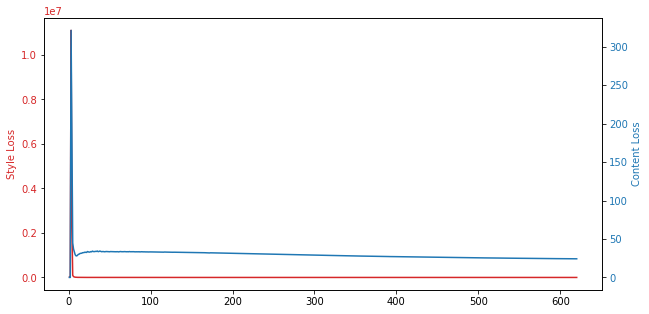

In [9]:
x = [r.run for r in results]
y1 = [r.style for r in results]
y2 = [r.content for r in results]

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.plot(x, y1, color=color)
ax1.set_ylabel('Style Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.plot(x, y2, color=color)
ax2.set_ylabel('Content Loss', color=color)
ax2.tick_params(axis='y', labelcolor=color)

## Visualize

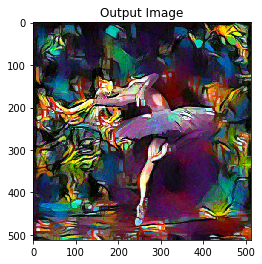

In [10]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()